# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from sklearn.metrics import mean_squared_error

# Load data

In [2]:
# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('Experiment_15_WGAN-GP.h5')
#G_model = tf.keras.models.load_model('WGAN_GP_3to1.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [3]:
X_test[:1].shape

(1, 30, 68)

In [4]:
X_test[:1]

array([[[-0.63224763, -0.63490122, -0.62825845, ..., -0.22729917,
         -0.56341887, -0.27163535],
        [-0.64009897, -0.63856532, -0.634062  , ..., -0.23307082,
         -0.56160313, -0.26423517],
        [-0.63522162, -0.63880172, -0.63212748, ..., -0.23896774,
         -0.5597605 , -0.25700908],
        ...,
        [-0.56063382, -0.56244644, -0.55244958, ..., -0.40929369,
         -0.50753443, -0.14599438],
        [-0.56729557, -0.57332057, -0.56635392, ..., -0.41630166,
         -0.50530599, -0.14462623],
        [-0.57229188, -0.57308417, -0.56502394, ..., -0.42327074,
         -0.50307507, -0.14349964]]])

In [5]:
# Get predicted data
y_predicted = G_model(X_test[:1])
rescaled_real_y = y_scaler.inverse_transform(y_test)
rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

In [6]:
# Set output steps
output_dim = y_test.shape[1]

## Predicted price
predict_result = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
  y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                           index=test_predict_index[i:i + output_dim])
  predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

In [7]:
len(y_predicted)

1

In [8]:
len(X_test)

730

In [9]:
rescaled_predicted_y

array([[44.12362324, 58.15264788, 46.15947885]])

# Helper Function

In [16]:
def PlotPredictedPrice(day, rescaled_Real_price_plots, rescaled_Predicted_price_plots, index, output_dim):
  reshaped_index = index[day:len(index) - (output_dim - 1 - day)]
  plt.figure(figsize=(16, 8))
  plt.plot(reshaped_index, rescaled_Real_price_plots[day])
  plt.plot(reshaped_index, rescaled_Predicted_price_plots[day], color = 'r')
  plt.xlabel("Date")
  plt.ylabel("Stock price")
  plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
  plt.title("Predicted Day " + str(day+1) + " Price", fontsize=20)
  plt.show()
  plt.savefig("predict_day" + str(day+1) + ".png")

In [21]:
def mda(predicted: np.ndarray, actual: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [24]:
def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real Mean price", "Predicted Mean price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    MDA = mda(predicted, real)
    print('-- MDA -- ', MDA)

    rescaled_Real_price_plots = np.swapaxes(rescaled_real_y,0,1)
    rescaled_Predicted_price_plots = np.swapaxes(rescaled_predicted_y,0,1)

    PlotPredictedPrice(0, rescaled_Real_price_plots, rescaled_Predicted_price_plots, real_price["real_mean"].index.tolist(), output_dim)
    MDA1 = mda(rescaled_Predicted_price_plots[0], rescaled_Real_price_plots[0])
    print('-- Day 1 MDA -- ', MDA1)

    PlotPredictedPrice(1, rescaled_Real_price_plots, rescaled_Predicted_price_plots, real_price["real_mean"].index.tolist(), output_dim)
    MDA2 = mda(rescaled_Predicted_price_plots[1], rescaled_Real_price_plots[1])
    print('-- Day 2 MDA -- ', MDA2)

    PlotPredictedPrice(2, rescaled_Real_price_plots, rescaled_Predicted_price_plots, real_price["real_mean"].index.tolist(), output_dim)
    MDA3 = mda(rescaled_Predicted_price_plots[2], rescaled_Real_price_plots[2])
    print('-- Day 3 MDA -- ', MDA3)

    return predict_result, RMSE

# Prediction

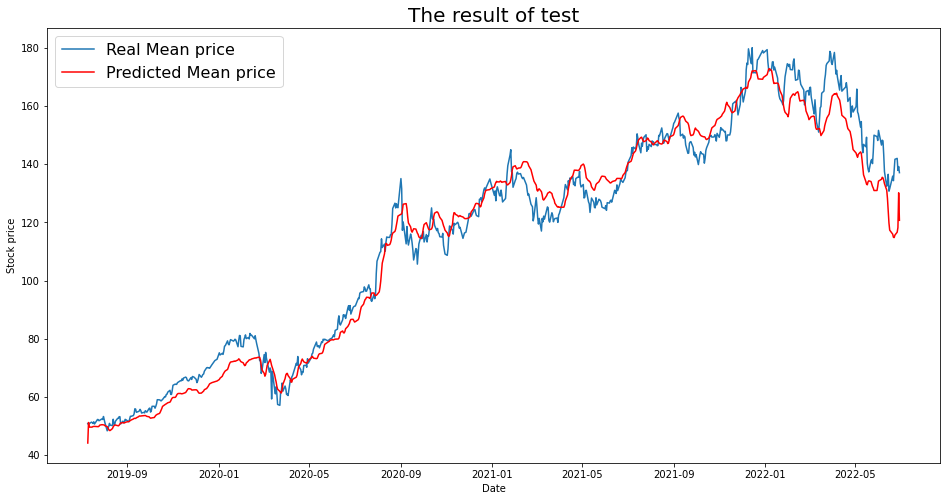

-- RMSE --  6.740126735111472
-- MDA --  0.9972677595628415


<Figure size 432x288 with 0 Axes>

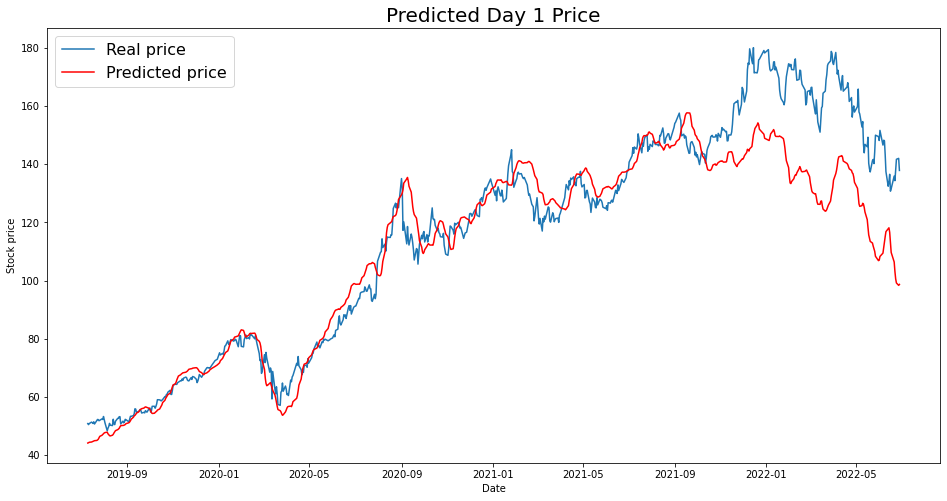

-- Day 1 MDA --  0.5157750342935528


<Figure size 432x288 with 0 Axes>

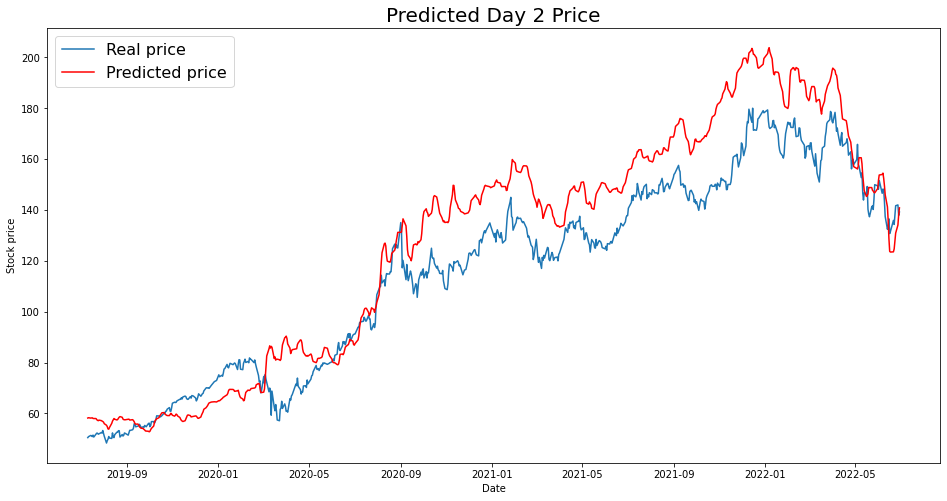

-- Day 2 MDA --  0.46502057613168724


<Figure size 432x288 with 0 Axes>

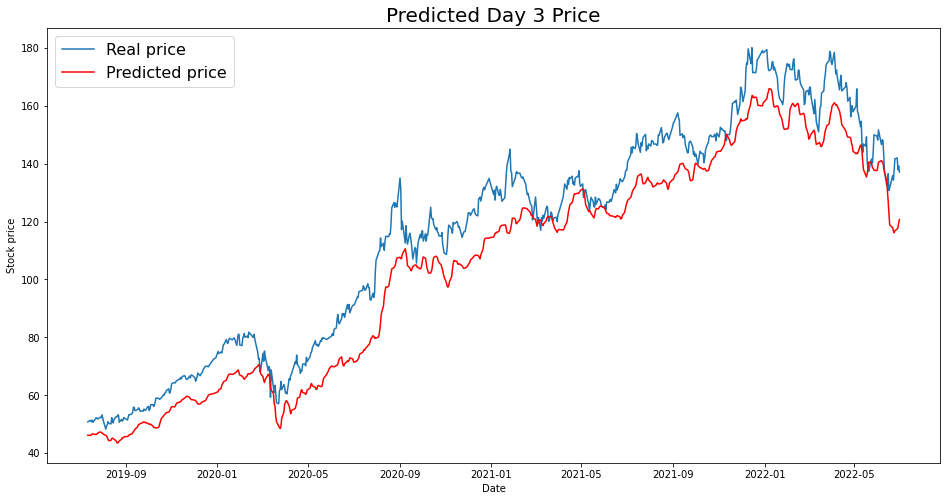

-- Day 3 MDA --  0.5089163237311386


<Figure size 432x288 with 0 Axes>

In [25]:
test_predicted, test_RMSE = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted.csv")

In [19]:
test_predicted.tail()

,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,...,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_price,predicted_mean
2022-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,116.798201,130.916055,99.151861,NaN,NaN,115.622039
2022-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,117.403819,134.089085,98.331616,NaN,116.608173
2022-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,117.871133,138.052944,98.656238,118.193439
2022-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.454701,140.833393,130.144047
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.694448,120.694448
